<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/bigearthnet%2Fvae/notebookd/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pretext Task: VAE

Adpated from: https://github.com/chenjie/PyTorch-CIFAR-10-autoencoder/blob/master/main.py

### Environment setup

In [1]:
!pip install ssl_remote_sensing@git+https://github.com/AlexanderLontke/ssl-remote-sensing.git@bigearthnet/vae

  Cloning https://github.com/AlexanderLontke/ssl-remote-sensing.git (to revision bigearthnet/vae) to /private/var/folders/3h/f64t3j9n2mj5djfz7mnt0_3h0000gn/T/pip-install-a1rquhnb/ssl-remote-sensing_d10f023b681e4a1685b74464eb0620c0
  Running command git clone --filter=blob:none --quiet https://github.com/AlexanderLontke/ssl-remote-sensing.git /private/var/folders/3h/f64t3j9n2mj5djfz7mnt0_3h0000gn/T/pip-install-a1rquhnb/ssl-remote-sensing_d10f023b681e4a1685b74464eb0620c0
  Running command git checkout -b bigearthnet/vae --track origin/bigearthnet/vae
  Switched to a new branch 'bigearthnet/vae'
  branch 'bigearthnet/vae' set up to track 'origin/bigearthnet/vae'.
  Resolved https://github.com/AlexanderLontke/ssl-remote-sensing.git to commit 29c15ae5b827b705376eb708a062776c4ff517c4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from ssl_remote_sensing.pretext_tasks.vae.utils import reproducibility, batch_mean_and_sd, imshow, print_model
from ssl_remote_sensing.data.bigearthnet.bigearthnet_dataloader import get_bigearthnet_dataloader
from ssl_remote_sensing.data.get_eurosat import get_eurosat_dataloader
from ssl_remote_sensing.models.ResNet18 import resnet18_encoder, resnet18_decoder
from ssl_remote_sensing.pretext_tasks.vae.model import VariationalAutoencoder

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: xuemei-jiang. Use `wandb login --relogin` to force relogin


True

In [6]:
# Numpy
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms


# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# OS
import os
import argparse

from torch import Tensor
from torchvision.datasets import EuroSAT
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torch.multiprocessing import cpu_count

import rasterio as rio
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# import cv2
# from albumentations.pytorch import ToTensorV2
# import albumentations as A

Machine setup

In [7]:
# Machine setup
available_gpus = torch.cuda.device_count()
print("available_gpus:", available_gpus)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

available_gpus: 0


In [8]:
import os

In [10]:
from google.colab import drive
drive.mount('/content/drive')
model_dir = '/content/drive/My Drive/deep_learning_vae_checkpoints'
model_path = os.path.join(model_dir,'vae_bigearthnet_allbands_lightning.ckpt')
assert os.path.exists(model_dir)

ModuleNotFoundError: No module named 'google.colab'

Saved model path setup

## Hyperparameter setup

In [8]:
# Model Setup
class Hparams:
    def __init__(self):
        self.pretext_epochs = 30 # number of training epochs for pretext tasks
        self.seed = 42  # randomness seed
        self.batch_size = 32
        self.lr = 1e-3
        self.latent_dim = 256
        self.optim = "Adam"
        self.cuda = True  # use coda
        self.transform = True
        self.split = False

In [9]:
train_config = Hparams()

In [10]:
reproducibility(train_config)

In [11]:
wandb.init(project="ssl-vae", config=train_config.__dict__)

wandb: Currently logged in as: xuemei-jiang. Use `wandb login --relogin` to force relogin



## Data


Description: EuroSAT, RGB, Normalized

In [12]:
# create Colab Notebooks directory
data_directory = '/content/data/'
if not os.path.exists(data_directory): os.makedirs(data_directory)

In [13]:
!cp -r /content/drive/MyDrive/bigearthnet.tar.gz /content/data/

In [14]:
!tar -xf /content/data/bigearthnet.tar.gz 

In [15]:
dataset_dir = "/content/BigEarthNet-v1.0/"

In [16]:
# TRY EUROSAT

In [17]:
if train_config.transform:

    transform = transforms.Compose(
                [transforms.Resize([128,128])])
else:
    transform = None

In [18]:
train_loader  = get_bigearthnet_dataloader(
    dataset_dir, batch_size = train_config.batch_size, num_workers = 1, dataset_transform =transform)

Loading samples: 100%|██████████| 100000/100000 [50:08<00:00, 33.24it/s]


In [19]:
next(iter(train_loader)).shape

torch.Size([32, 12, 128, 128])

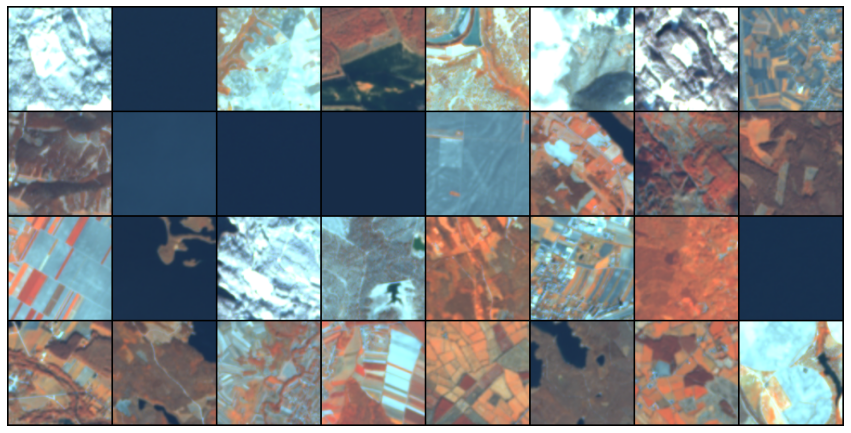

In [90]:
dataiter = iter(train_loader)
images = next(dataiter)
img_list = []
for image in images:
  img = image[[5, 4, 3], :, :]
  img_list.append(img)
  # print(img)
 
def show(img):
    fig, ax = plt.subplots(1, figsize=(15,15))
    plt.axis('off')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

grid = torchvision.utils.make_grid(img_list, nrow=8)
show(grid)

### Plot images

## Model setting

In [38]:
# set latent dimension
d  = train_config.latent_dim

model =  VariationalAutoencoder(latent_dim =d,input_height=128, config= train_config)
# model has been moved to device
model =  model.to(device)
print("[LOG] Latent dimension for VAE is: ", d)

[LOG] Latent dimension for VAE is:  256


In [39]:
# check if model is on cuda
print("[LOG] Is model on cuda? ", next(model.parameters()).is_cuda)

[LOG] Is model on cuda?  True


In [40]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 20102401.


In [41]:
# model

In [42]:
from pytorch_lightning.callbacks import GradientAccumulationScheduler, ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

save_model_path = os.path.join(model_dir,"saved_models/")

checkpoint_callback = ModelCheckpoint(
    filename=f"vae_allbands_bigearthnet_{train_config.batch_size}",
    dirpath=save_model_path,
    every_n_epochs=1,
    save_last=True,
    save_top_k=2,
    monitor="elb",
    mode="min",
)

# Setup WandB logging
wandb_logger = WandbLogger(
    project="ssl-vae",
    config=train_config.__dict__
)

shared_trainer_kwargs = {
    "callbacks": [checkpoint_callback],
    "max_epochs": train_config.pretext_epochs,
    "logger": wandb_logger,
    "log_every_n_steps": 1,
    "accelerator": "gpu",
}

trainer = pl.Trainer(**shared_trainer_kwargs)
trainer.fit(model, train_loader)
trainer.save_checkpoint(f"vae_allbands_bigearthnet_{train_config.batch_size}"+ ".ckpt")
wandb.save(checkpoint_callback.best_model_path)
wandb.finish()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.410    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:368: UserWarning: `ModelCheckpoint(monitor='elb')` could not find the monitored key in the returned metrics: ['elbo', 'kl', 'recon_loss', 'reconstruction', 'epoch', 'step']. HINT: Did you call `log('elb', value)` in the `LightningModule`?
  warning_cache.warn(m)
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


ValueError: ignored

In [52]:
bst_model = VariationalAutoencoder.load_from_checkpoint('/content/vae_allbands_bigearthnet_32.ckpt',latent_dim =256,input_height=128, config= train_config)

In [ ]:
def show(img):
    fig, ax = plt.subplots(1, figsize=(15,15))
    plt.axis('off')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

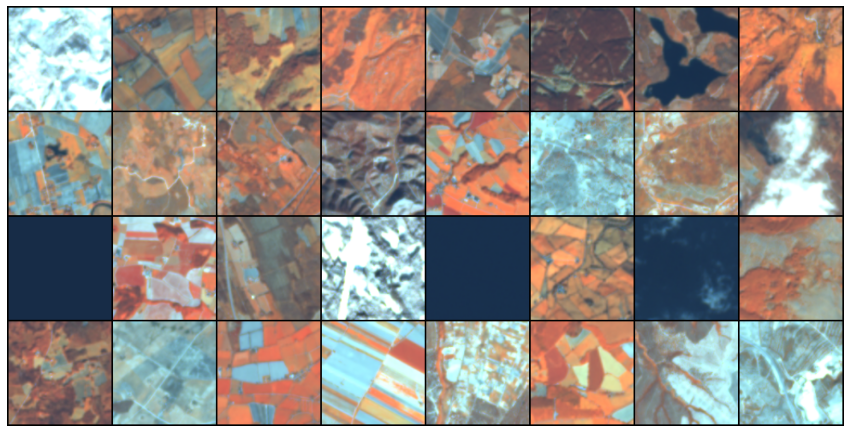

In [87]:
dataiter = iter(train_loader)
images = next(dataiter)
img_list = []
for image in images:
  img = image[[5, 4, 3], :, :]
  img_list.append(img)

grid = torchvision.utils.make_grid(img_list, nrow=8)
show(grid)

<Figure size 2400x900 with 0 Axes>

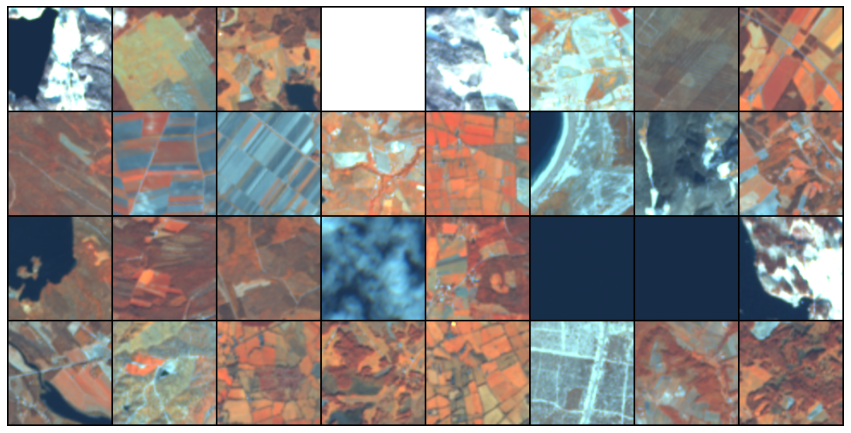

mu: torch.Size([32, 256])
log_var: torch.Size([32, 256])


torch.Size([32, 12, 128, 128])


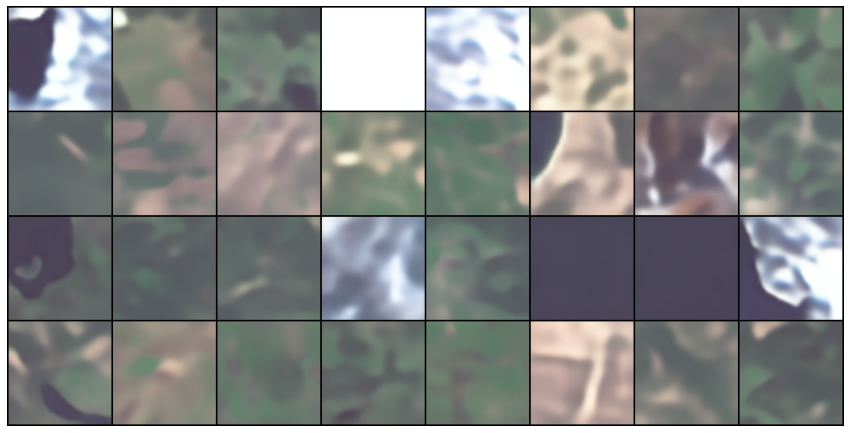

In [89]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
# from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

images = next(iter(train_loader))

img_list = []
for image in images:
  img = image[[5, 4, 3], :, :]
  img_list.append(img)

grid = torchvision.utils.make_grid(img_list, nrow=8)
show(grid)

pred_list = []

# print("sample shape",images[0].shape)

x_encoded = bst_model.encoder(images.float())
mu, log_var = bst_model.fc_mu(x_encoded), bst_model.fc_var(x_encoded)
print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)

# Z COMES FROM NORMAL(0, 1)
num_preds = 32
# mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
p = torch.distributions.Normal(mu, std)
# p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample()

# SAMPLE IMAGES
with torch.no_grad():
    pred = bst_model.decoder(z).cpu()
    print(pred.shape)

for image in pred:
    img = image[[3, 2, 1], :, :]
    pred_list.append(img.int())
grid = torchvision.utils.make_grid(pred_list, nrow=8)

# PLOT IMAGES
show(grid)